In [849]:
import src.paths

In [850]:
date = '2022-09-16'

In [851]:
%%time
spikes_raw = pd.read_pickle(src.paths.DATA / date / f'{date}-hpc-spikes.pkl')

CPU times: user 4.56 ms, sys: 664 ms, total: 668 ms
Wall time: 7.49 s


In [852]:
%%time
csd_raw = pd.read_pickle(src.paths.DATA / date / f'{date}-hpc-csd.pkl')

CPU times: user 54.4 ms, sys: 2.81 s, total: 2.86 s
Wall time: 33.7 s


---

In [853]:
START_SEC = 300 # start time in seconds
END_SEC = 1500  # end time in seconds
CHANNEL = 160

In [854]:
spikes = spikes_raw.loc[START_SEC:END_SEC - 1 / 250, CHANNEL - 4:CHANNEL + 3]
csd = csd_raw.loc[START_SEC:END_SEC - 1 / 1250, CHANNEL / 4] * 0.001

In [855]:
MIN_FREQ = 1  # max comb freq in Hz
MAX_FREQ = 100 # max comb freq in Hz
COMB_Q = 8

In [856]:
freqs = pd.Series(range(MIN_FREQ, MAX_FREQ + 1), name='frequency')
comb = pd.DataFrame(index=csd.index)
for w0 in tqdm.tqdm(freqs):
    b, a = scipy.signal.iirnotch(w0, Q=COMB_Q, fs=1250)
    comb[w0] = csd.values - scipy.signal.filtfilt(b, a, csd.values)

100%|██████████| 100/100 [00:02<00:00, 47.61it/s]


In [857]:
hilbert = scipy.signal.hilbert(comb)
phase = (np.angle(hilbert) + np.pi) / (2 * np.pi)
phase = pd.DataFrame(phase, index=comb.index, columns=comb.columns)

In [871]:
start = 647
end = 649

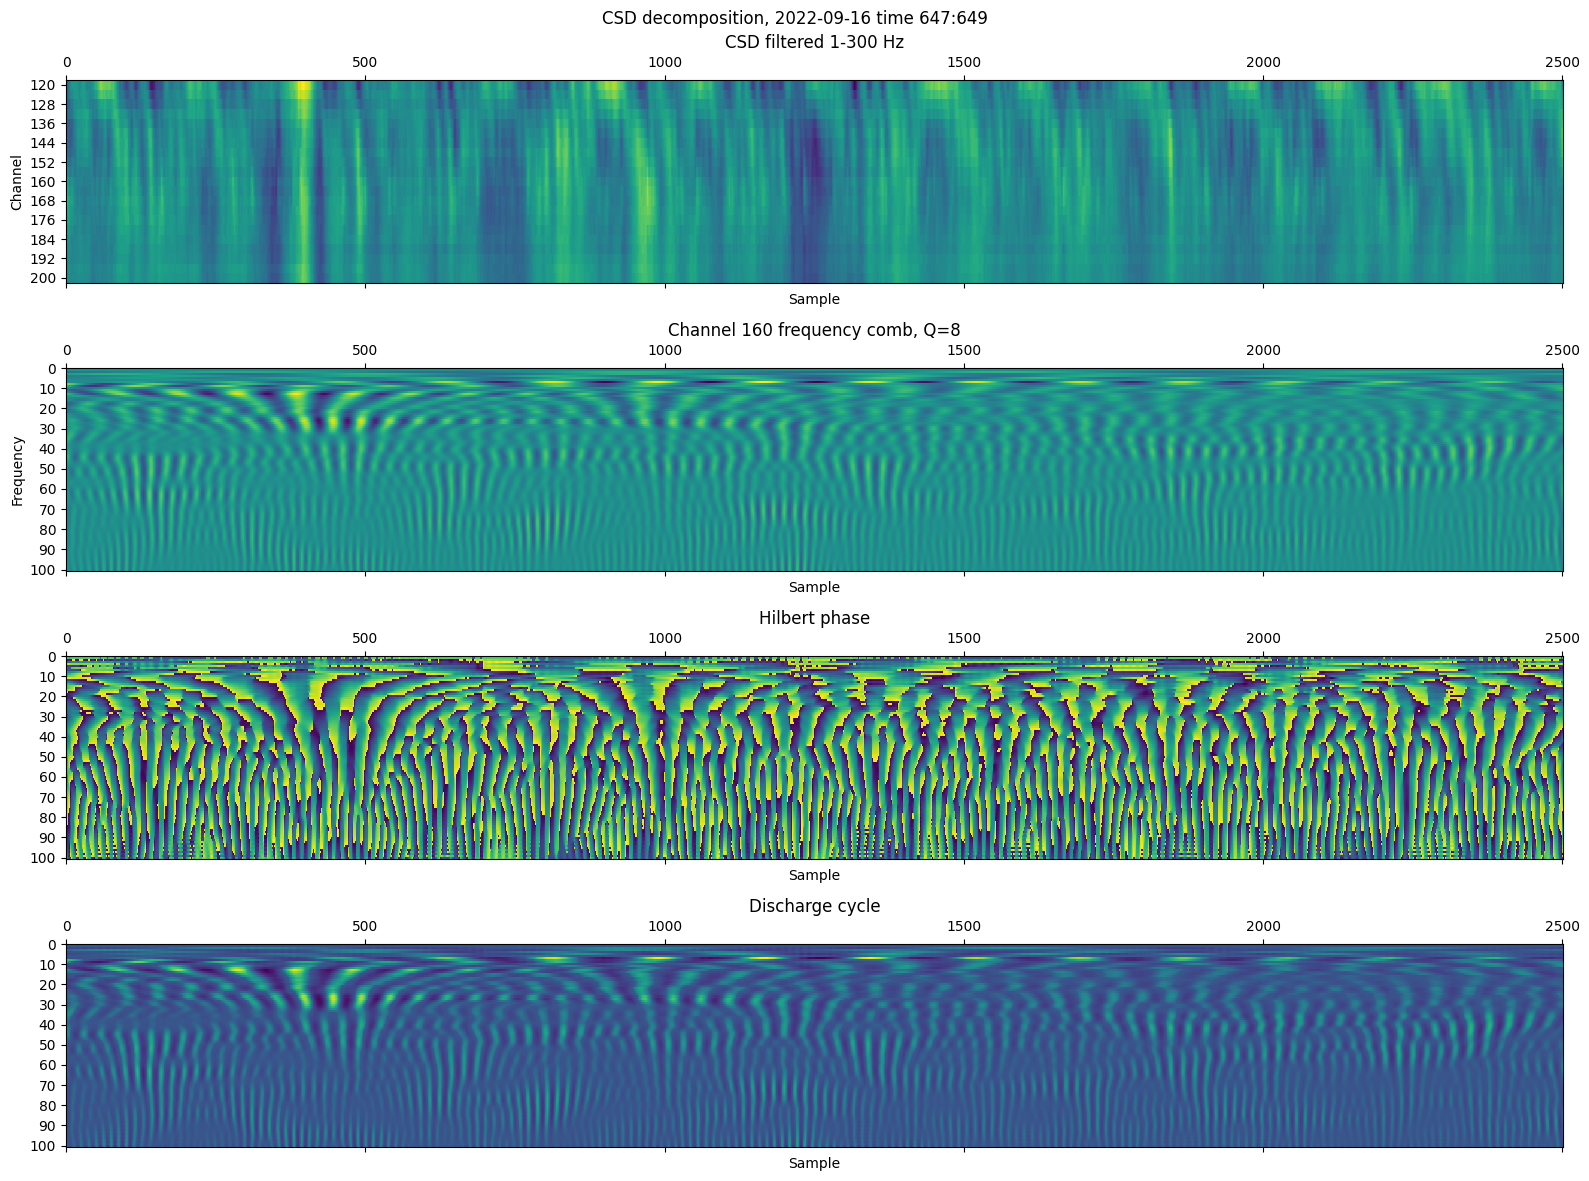

In [872]:
fig, ax = plt.subplots(4, 1, figsize=(16, 12))
plt.suptitle(f'CSD decomposition, {date} time {start}:{end}')

plt.sca(ax[0])
plt.title(f'CSD filtered 1-300 Hz')
plt.gca().matshow(csd_raw.loc[start:end, CHANNEL // 4 - 10:CHANNEL // 4 + 10].T)
plt.axis('auto')
plt.yticks(range(0, 21, 2), range(CHANNEL - 40, CHANNEL + 41, 8))
plt.ylabel('Channel')
plt.xlabel('Sample')

plt.sca(ax[1])
plt.title(f'Channel {CHANNEL} frequency comb, Q={COMB_Q}')
plt.gca().matshow(comb.loc[start:end].T)
plt.axis('auto')
plt.ylabel('Frequency')
plt.yticks(range(-1, MAX_FREQ, 10), range(0, MAX_FREQ + 1, 10))
plt.xlabel('Sample')

plt.sca(ax[2])
plt.title(f'Hilbert phase')
plt.gca().matshow(phase.loc[start:end].T)
plt.axis('auto')
plt.yticks(range(-1, MAX_FREQ, 10), range(0, MAX_FREQ + 1, 10))
plt.xlabel('Sample')

plt.sca(ax[3])
plt.title(f'Discharge cycle')
plt.gca().matshow(comb.loc[start:end].T * ((phase.loc[start:end].T + 0.25) % 1))
plt.axis('auto')
plt.yticks(range(-1, MAX_FREQ, 10), range(0, MAX_FREQ + 1, 10))
plt.xlabel('Sample')

plt.tight_layout()
plt.savefig(f'{date}-hpc-hilbert-time-{start}-{end}-channel-{CHANNEL}.png', dpi=300)
plt.show()

---

In [874]:
MIN_THETA = 2
MAX_THETA = 15
MIN_LOWGAMMA = 30
MAX_LOWGAMMA = 60
MIN_HIGAMMA = 60
MAX_HIGAMMA = 100

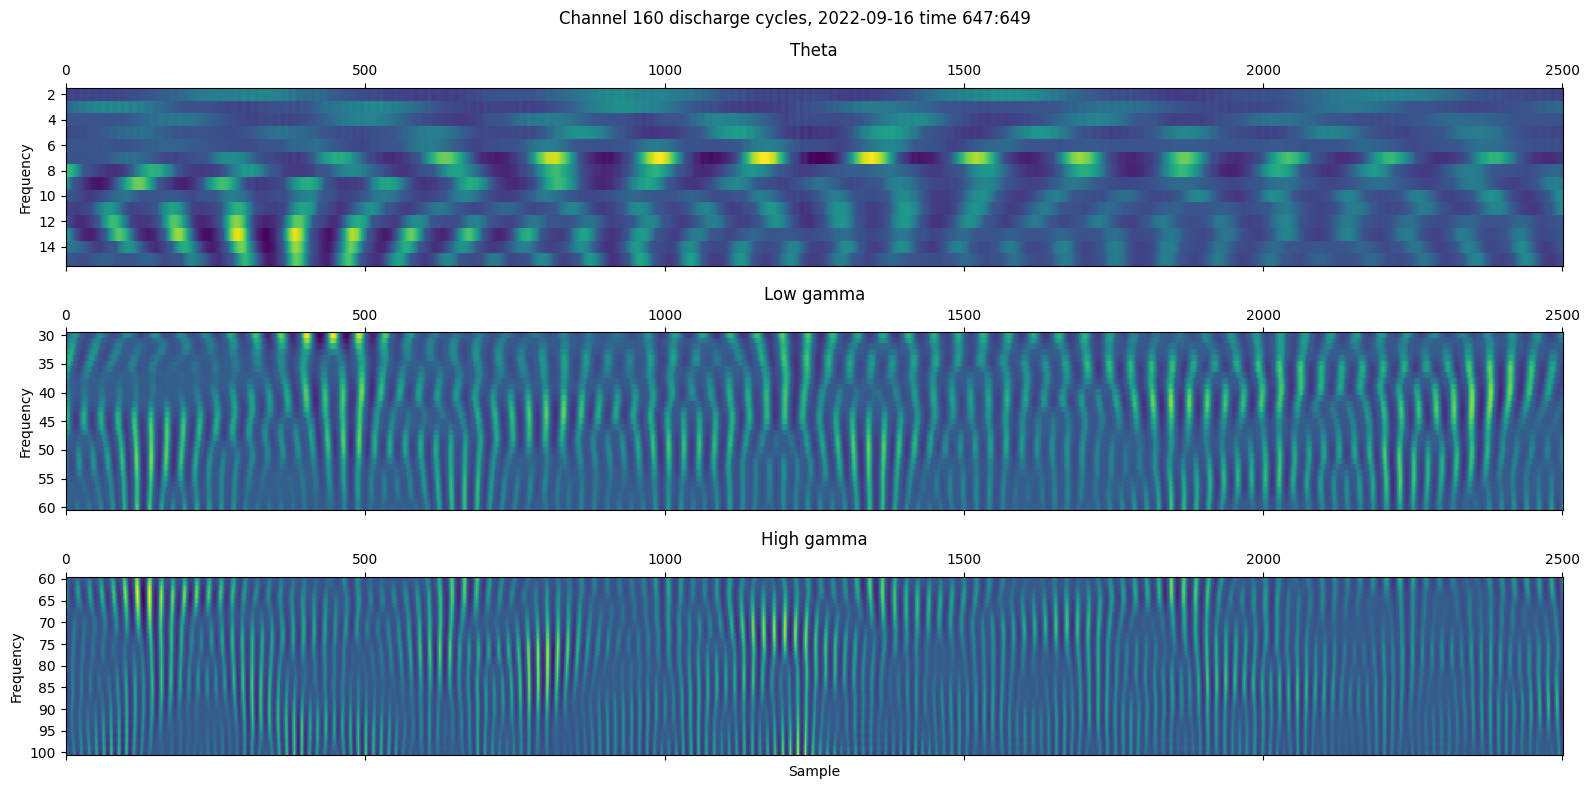

In [875]:
fig, ax = plt.subplots(3, 1, figsize=(16, 8))
plt.suptitle(f'Channel {CHANNEL} discharge cycles, {date} time {start}:{end}')

plt.sca(ax[0])
plt.title('Theta')
plt.gca().matshow(comb.loc[start:end, MIN_THETA:MAX_THETA].T * ((phase.loc[start:end, MIN_THETA:MAX_THETA].T + 0.25) % 1))
plt.axis('auto')
plt.yticks(range(0, MAX_THETA - MIN_THETA + 1, 2), range(MIN_THETA, MAX_THETA + 1, 2))
plt.ylabel('Frequency')

plt.sca(ax[1])
plt.title('Low gamma')
plt.gca().matshow(comb.loc[start:end, MIN_LOWGAMMA:MAX_LOWGAMMA].T * ((phase.loc[start:end, MIN_LOWGAMMA:MAX_LOWGAMMA].T + 0.25) % 1))
plt.axis('auto')
plt.yticks(range(0, MAX_LOWGAMMA - MIN_LOWGAMMA + 1, 5), range(MIN_LOWGAMMA, MAX_LOWGAMMA + 1, 5))
plt.ylabel('Frequency')

plt.sca(ax[2])
plt.title('High gamma')
plt.gca().matshow(comb.loc[start:end, MIN_HIGAMMA:MAX_HIGAMMA].T * ((phase.loc[start:end, MIN_HIGAMMA:MAX_HIGAMMA].T + 0.25) % 1))
plt.axis('auto')
plt.yticks(range(0, MAX_HIGAMMA - MIN_HIGAMMA + 1, 5), range(MIN_HIGAMMA, MAX_HIGAMMA + 1, 5))
plt.ylabel('Frequency')
plt.xlabel('Sample')

plt.tight_layout()
plt.savefig(f'{date}-hpc-cycles-time-{start}-{end}-channel-{CHANNEL}.png', dpi=300)
plt.show()

---

In [876]:
def downsample(df):
    t1 = pd.date_range(start=0, periods=len(df), freq='0.8ms')
    t2 = pd.date_range(start=0, periods=len(df) // 5, freq='4ms')
    tmp = df.set_index(t1)
    tmp = tmp.reindex(t2).interpolate(method='linear')
    return tmp.set_index(df.index[::5])

In [877]:
comb1 = downsample(comb)
phase1 = downsample(phase)

---

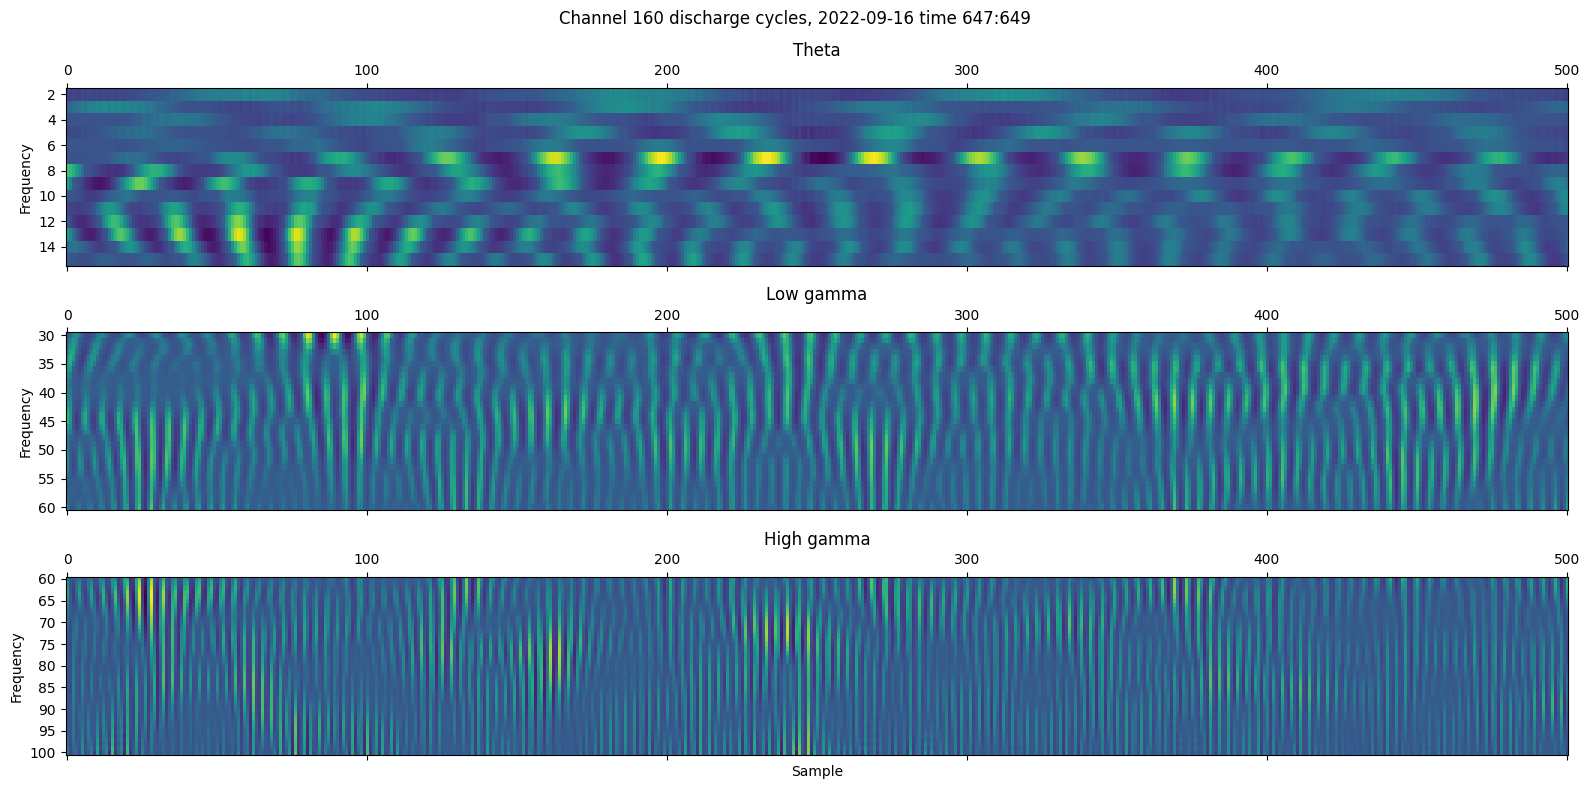

In [878]:
fig, ax = plt.subplots(3, 1, figsize=(16, 8))
plt.suptitle(f'Channel {CHANNEL} discharge cycles, {date} time {start}:{end}')

plt.sca(ax[0])
plt.title('Theta')
plt.gca().matshow(comb1.loc[start:end, MIN_THETA:MAX_THETA].T * ((phase1.loc[start:end, MIN_THETA:MAX_THETA].T + 0.25) % 1))
plt.axis('auto')
plt.yticks(range(0, MAX_THETA - MIN_THETA + 1, 2), range(MIN_THETA, MAX_THETA + 1, 2))
plt.ylabel('Frequency')

plt.sca(ax[1])
plt.title('Low gamma')
plt.gca().matshow(comb1.loc[start:end, MIN_LOWGAMMA:MAX_LOWGAMMA].T * ((phase1.loc[start:end, MIN_LOWGAMMA:MAX_LOWGAMMA].T + 0.25) % 1))
plt.axis('auto')
plt.yticks(range(0, MAX_LOWGAMMA - MIN_LOWGAMMA + 1, 5), range(MIN_LOWGAMMA, MAX_LOWGAMMA + 1, 5))
plt.ylabel('Frequency')

plt.sca(ax[2])
plt.title('High gamma')
plt.gca().matshow(comb1.loc[start:end, MIN_HIGAMMA:MAX_HIGAMMA].T * ((phase1.loc[start:end, MIN_HIGAMMA:MAX_HIGAMMA].T + 0.25) % 1))
plt.axis('auto')
plt.yticks(range(0, MAX_HIGAMMA - MIN_HIGAMMA + 1, 5), range(MIN_HIGAMMA, MAX_HIGAMMA + 1, 5))
plt.ylabel('Frequency')
plt.xlabel('Sample')

plt.tight_layout()
plt.savefig(f'{date}-hpc-cycles-time-{start}-{end}-channel-{CHANNEL}-250Hz.png', dpi=300)
plt.show()

In [879]:
df = spikes.loc[start:end - 1 / 250]
df = df.loc[:, df.sum(axis=0) > 0]
count = df.sum(axis=0)
count.index = count.index.droplevel('channel')

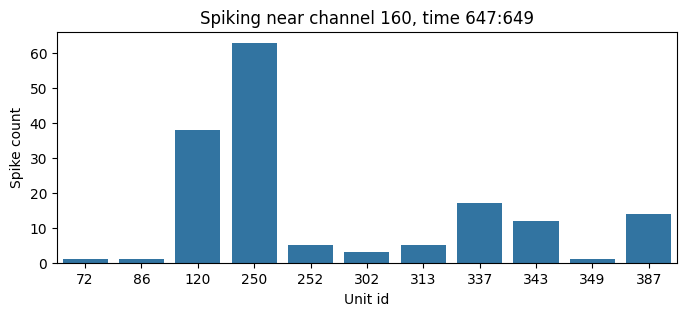

In [880]:
plt.figure(figsize=(8, 3))
sns.barplot(count)
plt.xlabel('Unit id')
plt.ylabel('Spike count')
plt.title(f'Spiking near channel {CHANNEL}, time {start}:{end}')
plt.show()